 We import slightly cleaned up versions of human mortality data available on the Human Mortality Database: https://www.mortality.org/Data/DataAvailability

 Namely, we look at the Death Counts data for all available countries (only ~40, note), which give us for each year and age the number of
 individuals in the given country that died at that age in the given year. We restrict to ages >= 10 and years >= 2000. 
 Ages >=110 are all grouped into age 110 in the HMD.

We then process the data by country and plot a graph of number of deaths as a function of age

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import numpy as np
from scipy.stats import gumbel_l, gumbel_r  # For the left-skewed (min) Gumbel distribution
from scipy.stats import probplot

# Suppress all (deprecation) warnings
warnings.filterwarnings("ignore")

countries = ["AUS", "AUT", "BGR", "BLR", "CAN", "CHE", "CHL", "CZE", "DEUTNP", "DNK", "ESP", "EST", "FIN", "GBRTENW", 
             "GRC", "HKG", "HRV", "HUN", "IRL", "ISL", "ISR", "ITA", "JPN", "KOR", "LTU", "LUX", "LVA", "NLD", "NOR", 
             "NZL_NP", "POL", "PRT", "RUS", "SVK", "SVN", "SWE", "UKR", "USA"] #something wrong with BEL file, skipped

for s in countries:   
    df = pd.read_csv(f"{s}.Deaths_1x1.txt", delim_whitespace = True)

    # Save as CSV
    df.to_csv("output.csv", index=False)

    # the data files have columns "Male", "Female", "Total". We will focus only on "Total".
    df.drop(["Female", "Male"], axis=1, inplace = True)
    df = df[df["Year"] >= 2000]
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")  # Converts to numeric, NaN for invalid entries

    # Restrict to ages >= 10
    df = df[df["Age"] >= 10]

    # Group by 'age' and sum the 'number' values across all years
    df = df.groupby("Age")["Total"].sum().reset_index()

    # plot Total number as function of Age
    plt.figure(figsize=(4, 3))
    plt.plot(df["Age"], df["Total"], linestyle="-", color="b")

    # Set plot labels and title
    plt.xlabel("Age")
    plt.ylabel("Total")
    plt.title(s)

    # Show the plot
    plt.show()

Here are some of the graphs:

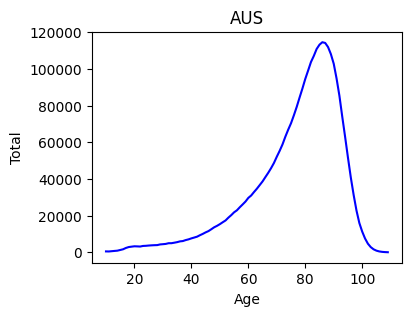  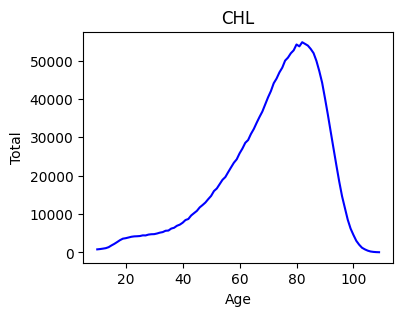   

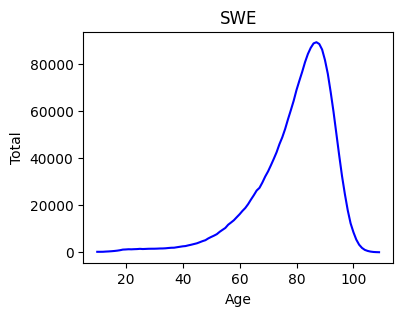 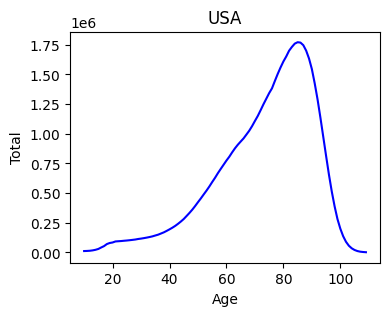

Here is Luxembourg, with its relatively tiny population:


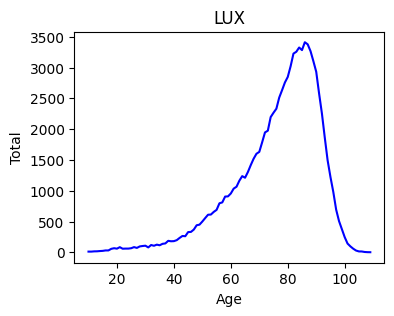

These totals clearly follow a **Gumbel distribution**. More precisely, these graphs look lower Gumbel distributed (or "min Gumbel"). These distributions arise in extreme value theory, and in the case of the min Gumbel distribution, what is being measured is the weakest component failure in a system.

The max Gumbel distribution is more widely used, and we achieve that for our data by simply putting a minus sign in front of our Age parameter.

The pdf of a max Gumbel distribution is given by $f(x) = \frac{1}{\beta} e^{-z - e^{-z}}$, where $z = \frac{x - \mu}{\beta}$. Here $\mu$ and $\beta$ are the location and scale parameters, respectively. The mean and standard deviation are linear combinations of $\mu, \beta$. Namely, the mean is given by $\mu + \beta \gamma$, where $\gamma$ is the Euler-Mascheroni constant; the variance is given by $\frac{\pi^2}{6}\beta^2$ (where $\frac{\pi^2}{6}$ is the Basel constant). 

We can therefore estimate the parameters of our max Gumbel distribution from our sample means and sample variances.

We keep track of $\mu$, $\beta$, mean, and variance for each country in the array parameters_list. We also record, as the last parameter in parameters_list, the GDP per capita in 2023 for each country. This data is collected from World Bank Group, https://data.worldbank.org/indicator/NY.GDP.PCAP.CD .


In [ ]:

# The above was preliminary, just to see the graphs. Now we go through the countries again and calculate the corresponding approximate parameters
# for the Gumbel distribution.

parameter_list = []  #each entry is [country code, mu, beta, mean, variance, gdp per capita]

countries = ["AUS", "AUT", "BGR", "BLR", "CAN", "CHE", "CHL", "CZE", "DEUTNP", "DNK", "ESP", "EST", "FIN", "GBRTENW", "GRC",
             "HKG", "HRV", "HUN", "ISL", "ISR", "ITA", "JPN", "KOR", "LTU", "LVA", "NLD", "NOR", "NZL_NP", "POL", "PRT", "SVK", "SVN", "SWE", "UKR"]

# removed ["LUX", "IRL", "USA", "RUS"] outliers

test_countries = ["SVN", "SWE", "UKR"]


# gdp per capita by country code
#              
gdp_dct = {"AUS": 64821, "AUT": 56034, "BGR": 15886, "BLR": 7829, "CAN": 53431, "CHE": 99565, "CHL": 17068, "CZE": 31591, "DEUTNP": 54343, 
       "DNK": 68454, "ESP": 33509, "EST": 30133, "FIN": 52926, "GBRTENW": 49464, "GRC": 23401, "HKG": 50532, "HRV": 21866, "HUN": 22142, "IRL": 103888,
       "ISL": 79637, "ISR": 52642, "ITA": 39003, "JPN": 33767, "KOR": 33121, "LTU": 27786, "LUX": 128678, "LVA": 22501, "NLD": 64572, "NOR": 87925,
       "NZL_NP": 48281, "POL": 22057, "PRT": 36779, "RUS": 13817, "SVK": 24491, "SVN": 32610, "SWE": 55517, "UKR": 5070, "USA": 82769}      


for s in countries:  
    #print(s)
    df = pd.read_csv(f"{s}.Deaths_1x1.txt", delim_whitespace = True)

    # Save as CSV
    df.to_csv("output.csv", index=False)
    df.drop(["Female", "Male"], axis=1, inplace = True)
    df = df[df["Year"] >= 2000]
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")  # Converts to numeric, NaN for invalid entries
    df = df[df["Age"] >= 10]
    # Group by 'age' and sum the 'number' values across all years
    #print(df.head())
    df = df.groupby("Age")["Total"].sum().reset_index()
    
    df["Age"] = -df["Age"]


    # Compute sum of age * total
    weighted_sum = 0
    weighted_sum_squares = 0
    total_count = 0

    for _, row in df.iterrows():
        weighted_sum += row['Age'] * row['Total']
        weighted_sum_squares += (row['Age']**2) * row['Total']
        total_count += row['Total']

    # Compute sample mean
    sample_mean = weighted_sum / total_count if total_count > 0 else 0
    sample_var = (total_count*weighted_sum_squares - weighted_sum**2)/(total_count**2)

    gamma = 0.5772156649015329 # euler-mascheroni

    beta = math.sqrt(6*sample_var/(math.pi**2))
    mu = sample_mean - beta*gamma

    mean, var = sample_mean, sample_var

    parameter_list.append([s,mu,beta,mean,var])
    
   


for i in range(len(parameter_list)):
    parameter_list[i].append(gdp_dct[parameter_list[i][0]])
    parameter_list[i][1] = float(parameter_list[i][1])
    



    country         mu       beta       mean    variance    gdp
0       AUS -83.745575  12.153257 -76.730524  242.959482  64821
1       AUT -83.959020  11.015454 -77.600727  199.596691  56034
2       BGR -79.325288  10.507169 -73.260385  181.601713  15886
3       BLR -76.480207  12.320185 -69.368803  249.679555   7829
4       CAN -82.916228  12.172600 -75.890013  243.733483  53431
5       CHE -85.269870  10.983592 -78.929969  198.443697  99565
6       CHL -79.252146  13.528804 -71.443108  301.069893  17068
7       CZE -80.574876  10.800077 -74.340903  191.867834  31591
8    DEUTNP -83.366572  10.595489 -77.250689  184.667521  54343
9       DNK -83.104756  10.784576 -76.879730  191.317476  68454
10      ESP -84.671395  11.000395 -78.321795  199.051315  33509
11      EST -79.349295  12.051546 -72.392953  238.909847  30133
12      FIN -83.260175  11.328799 -76.721015  211.113605  52926
13  GBRTENW -84.096418  11.056612 -77.714368  201.091016  49464
14      GRC -83.695637  10.753104 -77.48

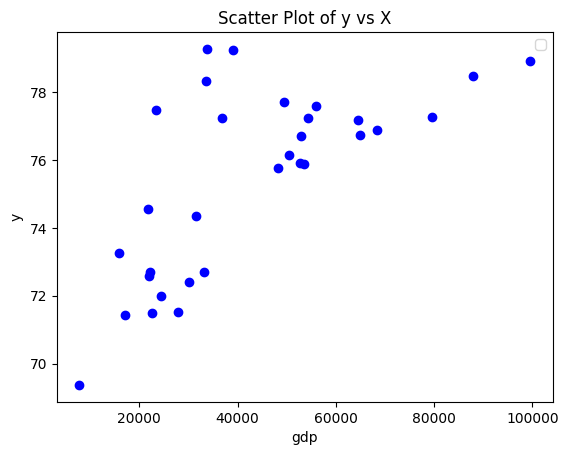

In [320]:
data = parameter_list

df = pd.DataFrame(data, columns=["country", "mu", "beta", "mean", "variance", "gdp"])

print(df)

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

"""  3D scatterplot
# Extract (mu, beta) as the independent variables (X) and GDP as the dependent variable (y)
X = np.array([[mean, var] for _, _, _, mean, var, _ in data])   # code, mu, beta, mean, var, gdp
y = np.array([gdp for _, _, _, _, _, gdp in data])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with mu, beta on x, y axes and GDP on z-axis
ax.scatter(X[:, 0], X[:, 1], y, c='blue', marker='o')

# Adding labels
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.set_zlabel('gdp')
ax.set_title('3D Scatter Plot of parameters, and GDP')



ax.view_init(elev=0, azim=90)

plt.show()  # Final show to keep the plot open after rotation
"""

X = np.array([gdp for _, _, _, _, _, gdp in data])
y = np.array([-mean for _, _, _, mean, _, _ in data])   # code, mu, beta, mean, var, gdp
#y = np.array([var for _, _, _, _, var, _ in data])   # code, mu, beta, mean, var, gdp
#y = np.array([beta for _, _, beta, _, _, _ in data])   # code, mu, beta, mean, var, gdp


#X = X/10000
#y -= np.min(y)
#y+=10

# Create a scatter plot
plt.scatter(X, y, color='blue')





corr_matrix = np.corrcoef(X, y)
print(corr_matrix)

# Adding labels and title
plt.xlabel('gdp')
plt.ylabel('y')
plt.title('Scatter Plot of y vs X')

# Show the plot
plt.legend()
plt.show()

Logarithmic Fit R² Score: 0.572


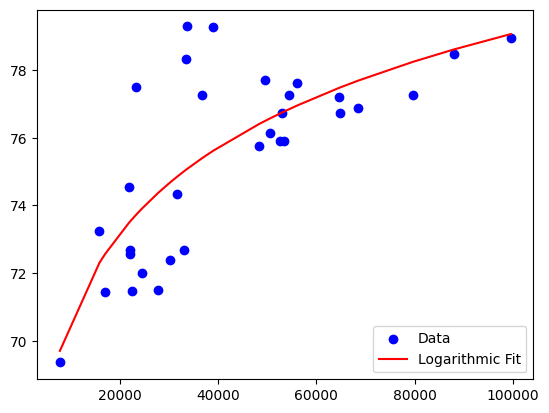

Fitted parameters: a = 36.7637967589312, b = 3.674998570092405
Log-transformed X: [ 8.96559007  9.6731935   9.74496064  9.9926882  10.00138529 10.00523154
 10.02131503 10.06053404 10.10606098 10.23228758 10.3133762  10.36062755
 10.4079228  10.41956934 10.42723927 10.51268231 10.57139385 10.78479339
 10.80900041 10.83036208 10.87126956 10.87664999 10.88614638 10.90307109
 10.93371393 11.07553616 11.0793849  11.13391727 11.28523409 11.38423946
 11.50856598]


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.clf()

# Example Data (X needs to be 2D)

"""
X = X.reshape(-1,1)

# Fit Linear Regression Model on All Data
model = LinearRegression()
model.fit(X, y)

# Predict y using the same X
y_pred = model.predict(X)
# Compute R² Score
r2 = r2_score(y, y_pred)

# Print Results
print(f"Model Coefficient (Slope): {model.coef_[0]:.3f}")
print(f"Model Intercept: {model.intercept_:.3f}")
print(f"R² Score: {r2:.3f}")

# Optional: Plot results
import matplotlib.pyplot as plt

plt.scatter(X, y, color="blue", label="Actual Data")
plt.plot(X, y_pred, color="red", linewidth=2, label="Fitted Line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Linear Regression: Fit on All Data")
plt.show()


#######
"""

#X = np.array(X).flatten()
#y = np.array(y).flatten()

sorted_pairs = sorted(zip(X, y))  # Creates sorted pairs (X, Y)
X_sorted, y_sorted = zip(*sorted_pairs)  # Unzips into separate lists

X = list(X_sorted)
y = list(y_sorted)

from scipy.optimize import curve_fit


def log_func(x, a, b):
    return a + b * np.log(x)

params, _ = curve_fit(log_func, X, y)
y_pred = log_func(X, *params)
r2 = r2_score(y, y_pred)

print(f"Logarithmic Fit R² Score: {r2:.3f}")

plt.scatter(X, y, color="blue", label="Data")
plt.plot(X, y_pred, color="red", label="Logarithmic Fit")
plt.legend()
plt.show()

print(f"Fitted parameters: a = {params[0]}, b = {params[1]}")
print("Log-transformed X:", np.log(X))




In [ ]:
powerfuls = []

def partition_sums(s):

    if not s:
        return set([0])

    ans = set()

    def helper(current,remaining):

        if not remaining:

            ans.add(current)
        else:
            print(current+int(remaining))
            ans.add(current+int(remaining))
            for i in range(1,len(remaining)):

                helper(current+int(remaining[:i]),remaining[i:])

    for i in range(len(s)):
        if i>0:
            helper(int(s[:i]),s[i:])
        else:
            helper(0,s)
    
    return ans




for n in range(1, 1001):
    s = str(n**2)
    for i in range(len(s)):
        diff = n - int(s[:i]) if i > 0 else n
        if diff in partition_sums(s[i:]):
            powerfuls.append(n)
            break

print(powerfuls)




1
4
9
16
7
7
6
25
7
7
5
36
9
9
6
49
13
13
9
64
10
10
4
81
9
9
100
1
1
10
1
1
10
121
22
4
13
22
4
13
21
3
3
1
144
45
9
18
45
9
18
44
8
8
4
169
70
16
25
70
16
25
69
15
15
9
196
97
16
25
97
16
25
96
15
15
6
225
27
9
27
27
9
27
25
7
7
5
256
58
13
31
58
13
31
56
11
11
6
289
91
19
37
91
19
37
89
17
17
9
324
27
9
36
27
9
36
24
6
6
4
361
64
10
37
64
10
37
61
7
7
1
400
4
4
40
4
4
40
0
0
0
0
441
45
9
45
45
9
45
41
5
5
1
484
88
16
52
88
16
52
84
12
12
4
529
34
16
61
34
16
61
29
11
11
9
576
81
18
63
81
18
63
76
13
13
6
625
31
13
67
31
13
67
25
7
7
5
676
82
19
73
82
19
73
76
13
13
6
729
36
18
81
36
18
81
29
11
11
9
784
91
19
82
91
19
82
84
12
12
4
841
49
13
85
49
13
85
41
5
5
1
900
9
9
90
9
9
90
0
0
0
0
961
70
16
97
70
16
97
61
7
7
1
1024
25
25
7
7
34
16
106
25
25
7
7
34
16
106
24
24
6
6
24
6
6
24
6
6
4
1089
90
90
18
18
99
27
117
90
90
18
18
99
27
117
89
89
17
17
89
17
17
89
17
17
9
1156
157
58
13
22
67
22
121
157
58
13
22
67
22
121
156
57
12
21
57
12
21
56
11
11
6
1225
226
28
10
28
37
19
127
226
2